In [1]:
import pathos.multiprocessing as multiprocessing
import dill as pickle
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
import matplotlib.pyplot as plt

from py_analyze_tools.sklearn import BasisFunctionConfiguration, ReaDDyElasticNetEstimator

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# simple sklearn estimator integration 

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_.h5")
traj.counts = traj.counts[:45*500]
traj.update()

max counts = 6000.0, min nonzero counts = 1.0


In [3]:
bfc = BasisFunctionConfiguration(traj)
bfc.add_fusion(0, 1, 2)
bfc.add_fission(2, 0, 1)
bfc.add_conversion(0, 1)
bfc.add_conversion(0, 3)
bfc.add_conversion(3, 0)

In [4]:
scale = 1. / (2. * traj.n_species * traj.n_time_steps)
estimator = ReaDDyElasticNetEstimator(traj, bfc, scale, alpha=200, l1_ratio=0.5)

In [5]:
dcounts_dt = np.gradient(traj.counts, axis=0) / traj.time_step
estimator.fit(None, None)

ReaDDyElasticNetEstimator(alpha=200,
             basis_function_configuration=<py_analyze_tools.sklearn.BasisFunctionConfiguration object at 0x7fdabbbab8d0>,
             init_xi=array([ 0.5,  0.5,  0.5,  0.5,  0.5]), l1_ratio=0.5,
             scale=5.555555555555556e-06,
             trajs=[<py_analyze_tools.tools.Trajectory object at 0x7fdaec126550>])

<IPython.core.display.Javascript object>


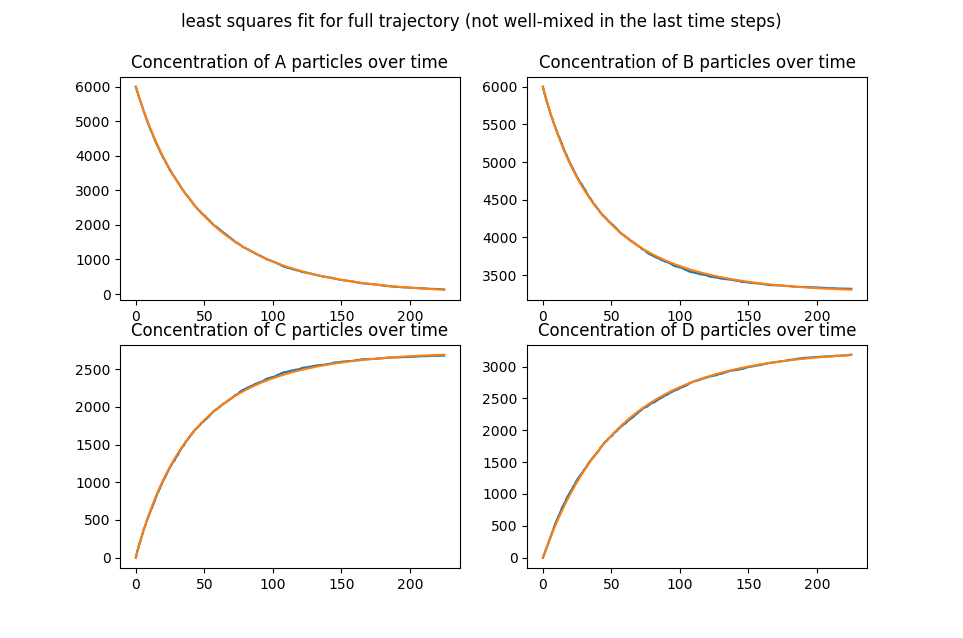

In [6]:
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(estimator.coefficients_, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

# grid search

In [7]:
traj = pat.Trajectory("../generate/simple_trajectory_.h5")
traj.counts = traj.counts[:45*500]
traj.update()
bfc = BasisFunctionConfiguration(traj)
bfc.add_fusion(0, 1, 2)
bfc.add_fission(2, 0, 1)
bfc.add_conversion(0, 1)
bfc.add_conversion(0, 3)
bfc.add_conversion(3, 0)
estimator = ReaDDyElasticNetEstimator(traj, bfc, 1. / (2. * traj.n_species * traj.n_time_steps))

max counts = 6000.0, min nonzero counts = 1.0


In [8]:
parameter_grid = []
for alpha in np.arange(0, 300, 50):
    for l1_ratio in np.arange(0, 1, .2):
            parameter_grid.append({
                'alpha': [alpha], 
                'l1_ratio': [l1_ratio], 
                'init_xi': [np.random.random(bfc.n_basis_functions) for _ in range(5)]})
# parameter_grid = {'alpha': np.arange(0, 300, 50), 'l1_ratio': np.arange(0, 1, .2)}
cv = TimeSeriesSplit(3)
gs = GridSearchCV(estimator, parameter_grid, n_jobs=8, cv=cv)

In [9]:
gs.fit(range(0, traj.n_time_steps), y=traj.dcounts_dt)

GridSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
       estimator=ReaDDyElasticNetEstimator(alpha=1.0,
             basis_function_configuration=<py_analyze_tools.sklearn.BasisFunctionConfiguration object at 0x7fdab81ed898>,
             init_xi=array([ 0.5,  0.5,  0.5,  0.5,  0.5]), l1_ratio=1.0,
             scale=5.555555555555556e-06,
             trajs=[<py_analyze_tools.tools.Trajectory object at 0x7fdab81ed358>]),
       fit_params={}, iid=True, n_jobs=8,
       param_grid=[{'alpha': [0], 'l1_ratio': [0.0], 'init_xi': [array([ 0.90426,  0.92774,  0.73372,  0.73526,  0.8306 ]), array([ 0.0025 ,  0.52317,  0.71487,  0.81528,  0.65287]), array([ 0.82616,  0.89554,  0.10201,  0.77554,  0.07291]), array([ 0.03207,  0.93761,  0.05454,  0.54472,  0.11812]), array(....40716,  0.6313 ,  0.69304,  0.46796]), array([ 0.07522,  0.30745,  0.58221,  0.85137,  0.69935])]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [10]:
best_est = gs.best_estimator_

In [11]:
best_est.alpha

100

In [12]:
best_est.l1_ratio

0.20000000000000001

<IPython.core.display.Javascript object>


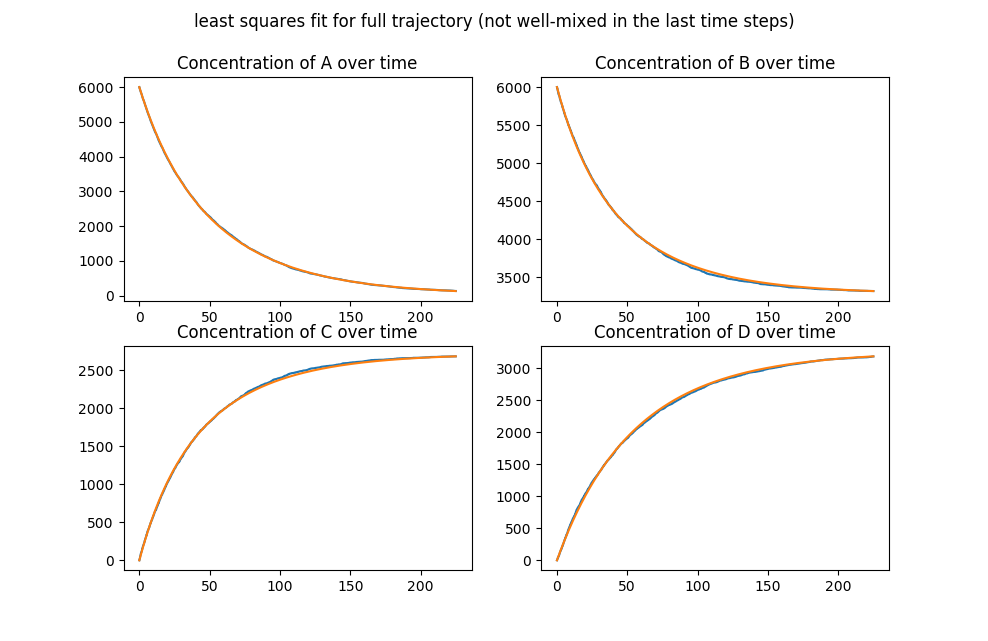

In [14]:
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(best_est.coefficients_, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s over time" % labels[i])
plt.show()

In [15]:
best_est.coefficients_

array([  1.92698320e-06,   7.64174707e-05,   0.00000000e+00,
         1.02407042e-02,   2.15160315e-05])

In [16]:
import functools
import operator
def rate_info(xi, diffusion_coefficient=.2, microscopic_rate=.05, reaction_radius=.7):
        tmp = np.sqrt(microscopic_rate / diffusion_coefficient) * reaction_radius
        rate_chapman = 4. * np.pi * diffusion_coefficient * reaction_radius * (1. - np.tanh(tmp) / tmp)
        rate_per_volume = xi * functools.reduce(operator.mul, [15,15,15], 1)

        print("erban chapman rate (per volume): {}".format(rate_chapman))
        print("lasso fitted rate (per counts): {}".format(xi))
        print("lasso fitted rate (per volume): {}".format(rate_per_volume))

        return rate_chapman, xi, rate_per_volume

In [17]:
rate_info(best_est.coefficients_)

erban chapman rate (per volume): 0.06848398371542153
lasso fitted rate (per counts): [  1.92698320e-06   7.64174707e-05   0.00000000e+00   1.02407042e-02
   2.15160315e-05]
lasso fitted rate (per volume): [  6.50356831e-03   2.57908963e-01   0.00000000e+00   3.45623765e+01
   7.26166064e-02]


(0.068483983715421526,
 array([  1.92698320e-06,   7.64174707e-05,   0.00000000e+00,
          1.02407042e-02,   2.15160315e-05]),
 array([  6.50356831e-03,   2.57908963e-01,   0.00000000e+00,
          3.45623765e+01,   7.26166064e-02]))

In [18]:
print(gs.best_params_)
print(gs.best_score_)
np.min(gs.cv_results_['mean_test_score'])

{'alpha': 100, 'init_xi': array([ 0.0302749 ,  0.4936785 ,  0.332961  ,  0.90975987,  0.42672325]), 'l1_ratio': 0.20000000000000001}
-2523.59406002


-2527.1214621029026

In [19]:
gs.cv_results_.keys()

dict_keys(['split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'param_init_xi', 'param_l1_ratio', 'params'])

<IPython.core.display.Javascript object>


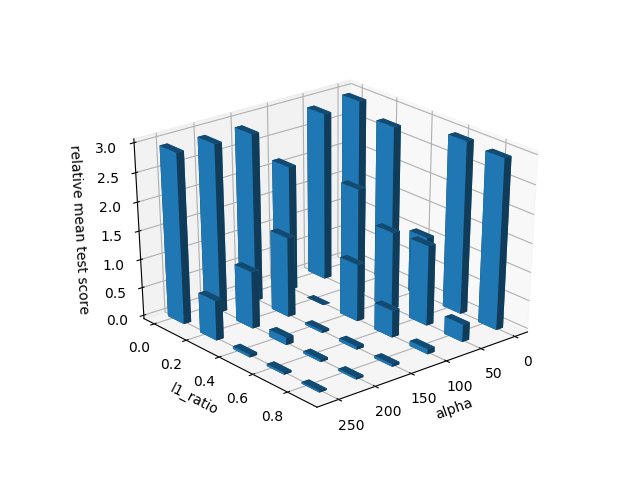

In [20]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x,y,z = [],[],[]
res = {}
for idx, param_set in enumerate(gs.cv_results_['params']):
    key = (param_set['alpha'], param_set['l1_ratio'])
    if key not in res.keys():
        res[key] = []
    res[key].append(gs.cv_results_['mean_test_score'][idx])
for key in res.keys():
    x.append(key[0])
    y.append(key[1])
    z.append(-1*np.max(res[key]))
x = np.array(x)
y = np.array(y)
z = np.array(z)
z = z - np.min(z)
ax.set_xlabel("alpha")
ax.set_ylabel("l1_ratio")
ax.set_zlabel("relative mean test score")
ax.bar3d(x,y,np.zeros(len(z)),10,.1,z)
plt.show()